# MC Dropout

In this tutorial, we explore using Monte Carlo (MC) dropout in Push. Dropout is a technique that can be used to improve training of NNs [1]. MC dropout extends dropout as a form of BDL [2]. This tutorial uses similar code to [this tutorial from the PyTorch site](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html).

## Dropout Layers in PyTorch

PyTorch supports dropout through the `torch.nn.`[Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html#torch.nn.Dropout) class. `Dropout` applies Bernoulli noise with a probability of $p$ to the input tensor and then scales the output by a factor of $\frac{1}{1-p}$ so that it acts as an identity function. Applying noise during training can [help prevent the model from overfitting to the train dataset](https://arxiv.org/abs/1207.0580).

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

random_data = torch.ones(5)
dropout = nn.Dropout(p=0.5)

# Same Dropout zeroes different outputs each time
# Scales to apply identity on average
with torch.no_grad():
    # will likely be different each time
    print("Input data:", random_data)
    print("1st iteration:", dropout(random_data))
    print("2nd iteration:", dropout(random_data))
    print("3rd iteration:", dropout(random_data))


Input data: tensor([1., 1., 1., 1., 1.])
1st iteration: tensor([0., 2., 0., 2., 2.])
2nd iteration: tensor([0., 0., 0., 0., 0.])
3rd iteration: tensor([0., 0., 2., 0., 0.])


## Dropout Example

Here we will show a simple dropout example using the classic Two Moons dataset. The goal is to classify each datapoint as being in the upper (0) or lower (1) dataset based solely on the input coordinate.

### Two Moons Dataset

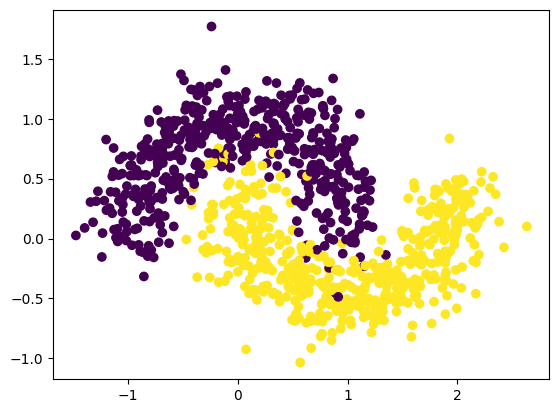

In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from sklearn.datasets import make_moons
from torch.utils.data import DataLoader, TensorDataset

# Create the dataset
X, y = make_moons(n_samples=1000, noise=0.2, shuffle=True)
train_X, train_y = X[:800], y[:800]
test_X, test_y = X[800:], y[800:]

# Convert to PyTorch Dataset
train_dataset = TensorDataset(torch.from_numpy(train_X).float(), torch.from_numpy(train_y).long())
test_dataset = TensorDataset(torch.from_numpy(test_X).float(), torch.from_numpy(test_y).long())

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

# Plot the Two Moon dataset
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

### Model

We define a `TwoMoonsModel` NN architecutre that contains 3 fully connected layers separated by two dropout layers.

In [3]:
class TwoMoonsModel(nn.Module):
    def __init__(self):
        super().__init__()
        # input layer
        self.fc1 = nn.Linear(2, 64)
        self.dropout1 = nn.Dropout(p=0.2)
        # hidden layers
        self.fc2 = nn.Linear(64, 64)
        self.dropout2 = nn.Dropout(p=0.2)
        # output layer
        self.fc3 = nn.Linear(64, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x

### Training

We can now train an instance of `TwoMoonsModel`.

In [4]:
dropout_model = TwoMoonsModel()
loss_fn = nn.CrossEntropyLoss()
optim = torch.optim.Adam(dropout_model.parameters(), lr=1e-4, weight_decay=1e-2)
epochs = 100

# Training loop
for i in range(epochs):
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        optim.zero_grad()

        outputs = dropout_model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optim.step()

        running_loss += loss.item()
    if i % 10 == 9:
        print(f'Epoch {i+1} loss: {running_loss}')

Epoch 10 loss: 13.216213315725327
Epoch 20 loss: 9.363578736782074
Epoch 30 loss: 7.959896296262741
Epoch 40 loss: 7.141156628727913
Epoch 50 loss: 7.139127895236015
Epoch 60 loss: 6.598731204867363
Epoch 70 loss: 6.306163743138313
Epoch 80 loss: 5.927408821880817
Epoch 90 loss: 5.610844627022743
Epoch 100 loss: 5.531881429255009


### Prediction

We can then turn the dropout off to evaluate the model on the test dataset.

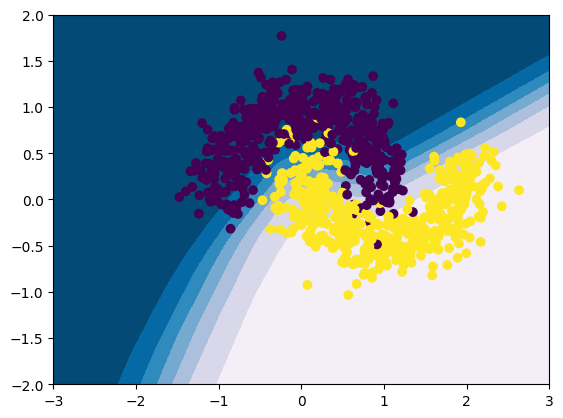

In [5]:
# Turn dropout off
dropout_model.eval()

# Inputs to use for plotting the decision boundary
XX, YY = np.meshgrid(np.linspace(-3.0, 3.0, 100), np.linspace(-2.0, 2.0, 100))
X_tensor = torch.tensor(XX, dtype=torch.float32)
Y_tensor = torch.tensor(YY, dtype=torch.float32)
inputs = torch.stack((X_tensor, Y_tensor), dim=2).view(-1, 2)

# Plot the class decision boundary
with torch.no_grad():
    outputs = dropout_model(inputs)
    ZZ = outputs.softmax(dim=1)[:,1].reshape((100,100))

    plt.contourf(XX, YY, ZZ, cmap=cm.PuBu_r)
    plt.scatter(X[:, 0], X[:, 1], c=y)
    plt.show()

## Monte Carlo Dropout

Using similar ideas to a normal dropout, Monte Carlo dropout creates a predictive distribution using dropout, but at evaluation time instead of only during training. By default, `Dropout` layers are only applied during training, not during testing. In order to run Monte Carlo dropout, during testing we need to enable and sample with the dropout applied.

In [6]:
# Show that the dropout layer is turned off during evaluation
print(nn.Dropout().train()(torch.ones(10))) # output is scaled up during training
print(nn.Dropout().eval()(torch.ones(10)))

tensor([0., 0., 2., 2., 2., 2., 0., 2., 0., 0.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


Once we've trained the model we can turn the dropout layers back on to do Monte Carlo dropout sampling.

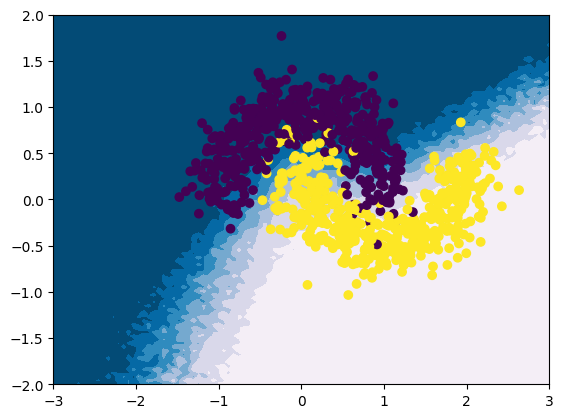

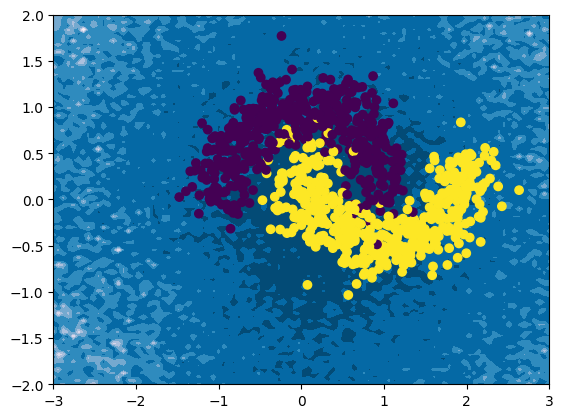

In [7]:
for module in dropout_model.modules():
    if isinstance(module, nn.Dropout):
        module.train()
sample_size = 10

# Plot the class decision boundary
with torch.no_grad():
    samples = []
    for i in range(sample_size):
        samples += [dropout_model(inputs)]
    outputs = torch.stack(samples, dim=1)
    mean_outputs = outputs.mean(dim=1).softmax(dim=1)[:, 1]
    std_outputs = outputs.softmax(dim=1).std(dim=1).max(dim=1).values
    ZZ_mean = mean_outputs.reshape((100,100))
    ZZ_std = std_outputs.reshape((100,100))

    plt.contourf(XX, YY, ZZ_mean, cmap=cm.PuBu_r)
    plt.scatter(X[:, 0], X[:, 1], c=y)
    plt.show()

    plt.contourf(XX, YY, ZZ_std, cmap=cm.PuBu_r)
    plt.scatter(X[:, 0], X[:, 1], c=y)
    plt.show()

As we can see from the above, the decision line is largely the same if noisier, but the standard deviation increases the further from the dataset we are.

## Using Push for Monte Carlo Dropout

Monte Carlo dropout can be sampled over multiple independently trained models to create a Multi Monte Carlo dropout distribution. An example of how to do this is given in the `MultiMCDropout` class in the module `push.bayes.mc_dropout`.

### Training

The function `train_mc_dropout` contains code for creating an ensemble of NNs that independently applies MC dropout. This technique thus combines the benefits of deep ensembles with MC dropout. Since Push enables working with arbitrary PyTorch modules such as `Dropout` and supports scaling of particles to efficiently implement ensembles across multi-GPU devices, we can get the best of both worlds with the Push implementation.

In [8]:
from push.bayes.mc_dropout import MultiMCDropout

mc_dropout = MultiMCDropout.train_mc_dropout(train_dataloader, loss_fn, epochs, TwoMoonsModel, patch=True, size_ensemble=3)

# Get all the samples
outputs = mc_dropout.posterior_pred(inputs, num_samples=3, f_reg=True, mode="raw")

  1%|          | 1/100 [00:00<00:44,  2.21it/s]

Average loss after epoch 0: 0.6789050102233887


 11%|█         | 11/100 [00:03<00:29,  2.99it/s]

Average loss after epoch 10: 0.45311132073402405


 21%|██        | 21/100 [00:07<00:26,  3.01it/s]

Average loss after epoch 20: 0.34269988536834717


 31%|███       | 31/100 [00:10<00:22,  3.00it/s]

Average loss after epoch 30: 0.30266880989074707


 41%|████      | 41/100 [00:13<00:19,  3.01it/s]

Average loss after epoch 40: 0.2836165726184845


 51%|█████     | 51/100 [00:17<00:16,  3.00it/s]

Average loss after epoch 50: 0.2752145528793335


 61%|██████    | 61/100 [00:20<00:13,  3.00it/s]

Average loss after epoch 60: 0.2604537904262543


 71%|███████   | 71/100 [00:23<00:09,  2.99it/s]

Average loss after epoch 70: 0.24525806307792664


 81%|████████  | 81/100 [00:27<00:06,  3.00it/s]

Average loss after epoch 80: 0.24862289428710938


 91%|█████████ | 91/100 [00:30<00:02,  3.01it/s]

Average loss after epoch 90: 0.23470240831375122


100%|██████████| 100/100 [00:33<00:00,  3.00it/s]


### Inference

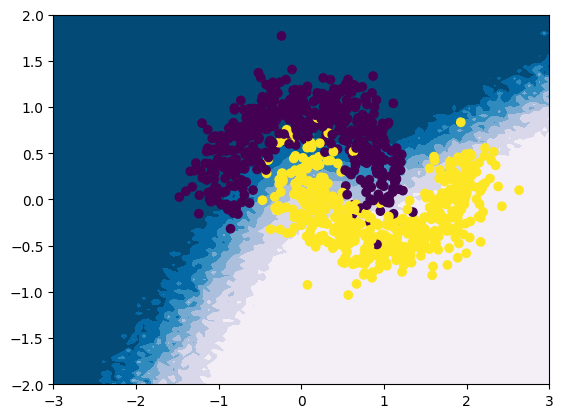

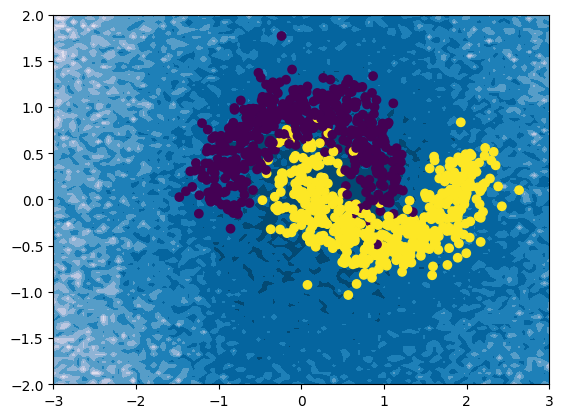

In [9]:
mean_outputs = outputs.mean(dim=1).softmax(dim=1)[:, 1]
std_outputs = outputs.softmax(dim=1).std(dim=1).max(dim=1).values
ZZ_mean = mean_outputs.reshape((100,100))
ZZ_std = std_outputs.reshape((100,100))

plt.contourf(XX, YY, ZZ_mean, cmap=cm.PuBu_r)
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

plt.contourf(XX, YY, ZZ_std, cmap=cm.PuBu_r)
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

## References

[1] Geoffrey E. Hinton, Nitish Srivastava, Alex Krizhevsky, Ilya Sutskever, Ruslan R. Salakhutdinov.. Improving neural networks by preventing co-adaptation of feature detectors. https://arxiv.org/abs/1207.0580.

[2] Yarin Gal and Zoubin Ghahramani. Dropout as a Bayesian Approximation: Representing Model Uncertainty in Deep Learning. Proceedings of The 33rd International Conference on Machine Learning, 2016.